In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3 as sqlite3
from scipy import stats
import numpy as np
import seaborn as sns

In [3]:
database_name = 'database.sqlite3'
conn = sqlite3.connect(database_name)
c = conn.cursor()

# SQL Queries

In [4]:
q = ("select * from sections")
sections =  pd.read_sql_query(q, conn)

q = ("select * from rooms")
rooms = pd.read_sql_query(q, conn)

q = ('select * from grade_distributions')
grade_distributions = pd.read_sql_query(q, conn)

q = ("select * from rooms r JOIN sections s WHERE r.uuid = s.room_uuid")
rooms_sections = pd.read_sql_query(q, conn)
     
q = ("select * from course_offerings")
course_offerings = pd.read_sql_query(q, conn)

q = ("select * from teachings")
teachings = pd.read_sql_query(q, conn)

q = ("select * from instructors")
instructors = pd.read_sql_query(q, conn)

# Data Cleaning

In [5]:
#renaming columns
course_offerings.rename(columns={'uuid':'course_offering_uuid'}, inplace=True)
instructors.columns = ['instructor_id', 'instructor_name']
rooms_sections.columns= ['room_uuid', 'facility_code', 'room_code', 'section_uuid', 'course_offering_uuid',
       'section_type', 'number', 'room_uuid2', 'schedule_uuid']

#drop columns
rooms_sections.drop('room_uuid2', axis=1, inplace=True)

#merge dataframes
df = rooms_sections.merge(grade_distributions, on='course_offering_uuid').merge(course_offerings, 
        on ='course_offering_uuid').merge(teachings, on ='section_uuid').merge(instructors, on = 'instructor_id')

#convert key values to numeric
for index, column in enumerate(df.iloc[:,8:-5]):
    df.iloc[:,(8+index)] = pd.to_numeric(df.iloc[:,(8+index)])
    
#drop rows where no grades
df.drop(df.loc[(df['a_count']==0) & (df['b_count']==0) & (df['c_count']==0) & (df['d_count']==0) & (df['f_count']==0) & (df['ab_count']==0)].index, inplace=True)

#drop rows where there are five or less grades
df.drop(df.loc[(df['a_count'] + df['b_count'] + df['c_count'] + df['d_count'] + df['f_count'] + df['ab_count']) <= 5].index, inplace= True)

#drop rows where room_code is 'null'
df.drop(df.loc[df['room_code']=='null'].index, inplace =True)


### Begin investigation with aim of finding two classrooms to focus on.

In [6]:
#drop the bottom quartile of rooms
#np.quantile(df['room_code'].value_counts(),.25)
num_rooms_to_drop = round(len(df.room_code.value_counts())*.25)
room_subset = [room for room in df['room_code'].value_counts().index[:-num_rooms_to_drop]]
df = df[df['room_code'].isin(room_subset)]

#df.instructor_id.value_counts().describe()
#np.quantile(df['instructor_id'].value_counts(),.99)
#np.quantile(df['instructor_id'].value_counts(),.25)

high_cutoff = round(len(df.room_code.value_counts())*.99)
low_cutoff = round(len(df.room_code.value_counts())*.25)

#  Grab a smaller subset of instructors, defined by the quantile range between .75 and .99 
#  of number of times the instructor appears in the dataframe.

instructors_subset = [instructor for instructor in df.instructor_id.unique()]
df = df[df.instructor_id.isin(instructors_subset[low_cutoff:high_cutoff])]

In [7]:
#Create a groupby object grouping by room, course, and instructor
df_groups = df.groupby(['room_code', 'course_uuid', 'instructor_id'])

group_names = []
for name, groups in df_groups:
    group_names.append(name)
    
#rename a columnn
df.rename(columns={'name':'course_name'}, inplace=True)

In [8]:
#list of the keys for the groupby object
group_names[0]

('0010', '0f028eba-ac26-36d3-b6f1-c18a72303e74', '3493329')

In [9]:
print(len(group_names), " - this is the number of unique room, course, and teacher groupings in the groupby object.")

3237  - this is the number of unique room, course, and teacher groupings in the groupby object.


In [10]:
#example of one group in the group by object
df_groups.get_group(group_names[0]).head(5)

room_uuid facility_code room_code  \
64037  f5bb3122-3653-3d4c-aec0-cd574c99420f          0070      0010   
64038  f5bb3122-3653-3d4c-aec0-cd574c99420f          0070      0010   
64039  f5bb3122-3653-3d4c-aec0-cd574c99420f          0070      0010   
64040  f5bb3122-3653-3d4c-aec0-cd574c99420f          0070      0010   
64041  f5bb3122-3653-3d4c-aec0-cd574c99420f          0070      0010   

                               section_uuid  \
64037  dbada0b2-0524-345d-83ee-dbfac60776b1   
64038  dbada0b2-0524-345d-83ee-dbfac60776b1   
64039  dbada0b2-0524-345d-83ee-dbfac60776b1   
64040  dbada0b2-0524-345d-83ee-dbfac60776b1   
64041  dbada0b2-0524-345d-83ee-dbfac60776b1   

                       course_offering_uuid section_type number  \
64037  f6d6aafb-b0b9-3141-9bd7-f1c7d313bbb9          LEC      5   
64038  f6d6aafb-b0b9-3141-9bd7-f1c7d313bbb9          LEC      5   
64039  f6d6aafb-b0b9-3141-9bd7-f1c7d313bbb9          LEC      5   
64040  f6d6aafb-b0b9-3141-9bd7-f1c7d313bbb9          LEC      5   
64041  f6d6aafb-b0b9-3141-9bd7-f1c7d313bbb9          LEC      5   

                              schedule_uuid  section_number  n_count  ...  \
64037  22b99e69-ae34-3577-bf01-899774ba3047               1        0  ...   
64038  22b99e69-ae34-3577-bf01-899774ba3047               2        0  ...   
64039  22b99e69-ae34-3577-bf01-899774ba3047               3        0  ...   
64040  22b99e69-ae34-3577-bf01-899774ba3047               4        0  ...   
64041  22b99e69-ae34-3577-bf01-899774ba3047               5        0  ...   

       a_count  s_count  i_count  b_count  nr_count  \
64037        9        0        0        3         0   
64038        7        0        0        1         0   
64039        4        0        0        4         0   
64040       10        0        0        2         0   
64041        6        0        0        1         0   

                                course_uuid  term_code  \
64037  0f028eba-ac26-36d3-b6f1-c18a72303e74       1174   
64038  0f028eba-ac26-36d3-b6f1-c18a72303e74       1174   
64039  0f028eba-ac26-36d3-b6f1-c18a72303e74       1174   
64040  0f028eba-ac26-36d3-b6f1-c18a72303e74       1174   
64041  0f028eba-ac26-36d3-b6f1-c18a72303e74       1174   

                    course_name  instructor_id  instructor_name  
64037  Science and Storytelling        3493329     JOSEPH QUICK  
64038  Science and Storytelling        3493329     JOSEPH QUICK  
64039  Science and Storytelling        3493329     JOSEPH QUICK  
64040  Science and Storytelling        3493329     JOSEPH QUICK  
64041  Science and Storytelling        3493329     JOSEPH QUICK  

[5 rows x 30 columns]

In [11]:
#calculates the ratio of the grade give rather than just the count
df_rci = pd.DataFrame(columns=['room_code','course_name','instructor_name', 'A','AB','B','C','D','F','room_uuid','course_uuid','instructor_id','term_code'])

#iterate through each of the groups
for index, group in enumerate(group_names):
    
    if df_groups.get_group(group_names[index]).shape[0]>=10:
        #iterate through each row in the current group
        hold_df = pd.DataFrame(columns=['room_code','course_name','instructor_name', 'A','AB','B','C','D','F','room_uuid','course_uuid','instructor_id','term_code'])
        for row_index in range(df_groups.get_group(group_names[index]).shape[0]):
            #take a sum across the row
            row_sum = np.array(df_groups.get_group(group_names[index]).iloc[row_index][['a_count','ab_count','b_count','c_count','d_count','f_count']]).sum()
            
            #update each grade count with ratio representing that grade count divided by the sum of all grades given across that row
            #df_groups.get_group(group_names[index]).loc[row_index] = [
            hold_df.loc[row_index] = [
                    
                                                            df_groups.get_group(group_names[index]).iloc[row_index]['room_code'],
                                                            df_groups.get_group(group_names[index]).iloc[row_index]['course_name'],
                                                            df_groups.get_group(group_names[index]).iloc[row_index]['instructor_name'],
                                                            df_groups.get_group(group_names[index]).iloc[row_index]['a_count']/row_sum,
                                                            df_groups.get_group(group_names[index]).iloc[row_index]['ab_count']/row_sum,
                                                            df_groups.get_group(group_names[index]).iloc[row_index]['b_count']/row_sum,
                                                            df_groups.get_group(group_names[index]).iloc[row_index]['c_count']/row_sum,
                                                            df_groups.get_group(group_names[index]).iloc[row_index]['d_count']/row_sum,
                                                            df_groups.get_group(group_names[index]).iloc[row_index]['f_count']/row_sum,
                                                            df_groups.get_group(group_names[index]).iloc[row_index]['room_uuid'],
                                                            df_groups.get_group(group_names[index]).iloc[row_index]['course_uuid'],
                                                            df_groups.get_group(group_names[index]).iloc[row_index]['instructor_id'],
                                                            df_groups.get_group(group_names[index]).iloc[row_index]['term_code']
                
                
                                                                            ]
        
        #append a row to a new dataframe containing arrays of ratios
        df_rci.loc[index] = [
                                hold_df['room_code'][0],
                                hold_df['course_name'][0],
                                hold_df['instructor_name'][0],
                                hold_df['A'],
                                hold_df['AB'],
                                hold_df['B'],
                                hold_df['C'],
                                hold_df['D'],
                                hold_df['F'],
                                hold_df['room_uuid'][0],
                                hold_df['course_uuid'][0],
                                hold_df['instructor_id'][0],
                                hold_df['term_code'][0]
                                
                            ]

#df_rci.rename(columns={'couse_uuid' : 'course_uuid'}, inplace=True)

#now regroup by room and course counts
rc_df = df_rci.groupby(['room_code','course_uuid']).count()

### Selecting classrooms to focus on

In [12]:
rc_df.loc[rc_df['A']>30]

course_name  instructor_name  \
room_code course_uuid                                                          
2170      fc10f135-3e48-3b54-ad16-e551abb3a85a           32               32   
2190      fc10f135-3e48-3b54-ad16-e551abb3a85a           40               40   
4013      7a552326-da08-354c-aafc-f56edcf83f44           38               38   
4018      7a552326-da08-354c-aafc-f56edcf83f44           42               42   

                                                 A  AB   B   C   D   F  \
room_code course_uuid                                                    
2170      fc10f135-3e48-3b54-ad16-e551abb3a85a  32  32  32  32  32  32   
2190      fc10f135-3e48-3b54-ad16-e551abb3a85a  40  40  40  40  40  40   
4013      7a552326-da08-354c-aafc-f56edcf83f44  38  38  38  38  38  38   
4018      7a552326-da08-354c-aafc-f56edcf83f44  42  42  42  42  42  42   

                                                room_uuid  instructor_id  \
room_code course_uuid                                                      
2170      fc10f135-3e48-3b54-ad16-e551abb3a85a         32             32   
2190      fc10f135-3e48-3b54-ad16-e551abb3a85a         40             40   
4013      7a552326-da08-354c-aafc-f56edcf83f44         38             38   
4018      7a552326-da08-354c-aafc-f56edcf83f44         42             42   

                                                term_code  
room_code course_uuid                                      
2170      fc10f135-3e48-3b54-ad16-e551abb3a85a         32  
2190      fc10f135-3e48-3b54-ad16-e551abb3a85a         40  
4013      7a552326-da08-354c-aafc-f56edcf83f44         38  
4018      7a552326-da08-354c-aafc-f56edcf83f44         42

In [13]:
#create a key for the rooms and courses groupby object
room_course_list = list(rc_df.loc[rc_df['A']>30].index)
room_course_list

[('2170', 'fc10f135-3e48-3b54-ad16-e551abb3a85a'),
 ('2190', 'fc10f135-3e48-3b54-ad16-e551abb3a85a'),
 ('4013', '7a552326-da08-354c-aafc-f56edcf83f44'),
 ('4018', '7a552326-da08-354c-aafc-f56edcf83f44')]

In [14]:
#now regroup by room and course sans count()
df_rc = df_rci.groupby(['room_code','course_uuid'])

In [15]:
#make lists of instructors in each room and count those lists
instructors_2170 = list(df_rc.get_group(room_course_list[0])['instructor_id'])
instructors_2190 = list(df_rc.get_group(room_course_list[1])['instructor_id'])
print(len(instructors_2170), len(instructors_2190), len(set(instructors_2170 + instructors_2190)))

32 40 64


In [39]:
df_rc.get_group(room_course_list[0]).head(2)

room_code                 course_name   instructor_name  \
1356      2170  Intro Financial Accounting   DANIEL WANGERIN   
1357      2170  Intro Financial Accounting  MATTHEW JUNEMANN   

                                                      A  \
1356  0     0.212121
1     0.233333
2     0.250000
3...   
1357  0     0.212121
1     0.233333
2     0.250000
3...   

                                                     AB  \
1356  0     0.000000
1     0.133333
2     0.125000
3...   
1357  0     0.000000
1     0.133333
2     0.125000
3...   

                                                      B  \
1356  0     0.363636
1     0.200000
2     0.406250
3...   
1357  0     0.363636
1     0.200000
2     0.406250
3...   

                                                      C  \
1356  0     0.242424
1     0.066667
2     0.156250
3...   
1357  0     0.242424
1     0.066667
2     0.156250
3...   

                                                      D  \
1356  0     0.151515
1     0.266667
2     0.031250
3...   
1357  0     0.151515
1     0.266667
2     0.031250
3...   

                                                      F  \
1356  0     0.030303
1     0.100000
2     0.031250
3...   
1357  0     0.030303
1     0.100000
2     0.031250
3...   

                                 room_uuid  \
1356  026d4b38-9cc3-361d-af8d-ef162119f51e   
1357  026d4b38-9cc3-361d-af8d-ef162119f51e   

                               course_uuid instructor_id term_code  
1356  fc10f135-3e48-3b54-ad16-e551abb3a85a       1546260      1094  
1357  fc10f135-3e48-3b54-ad16-e551abb3a85a       1552615      1094

Text(0.5, 0, "Percent A's Given")

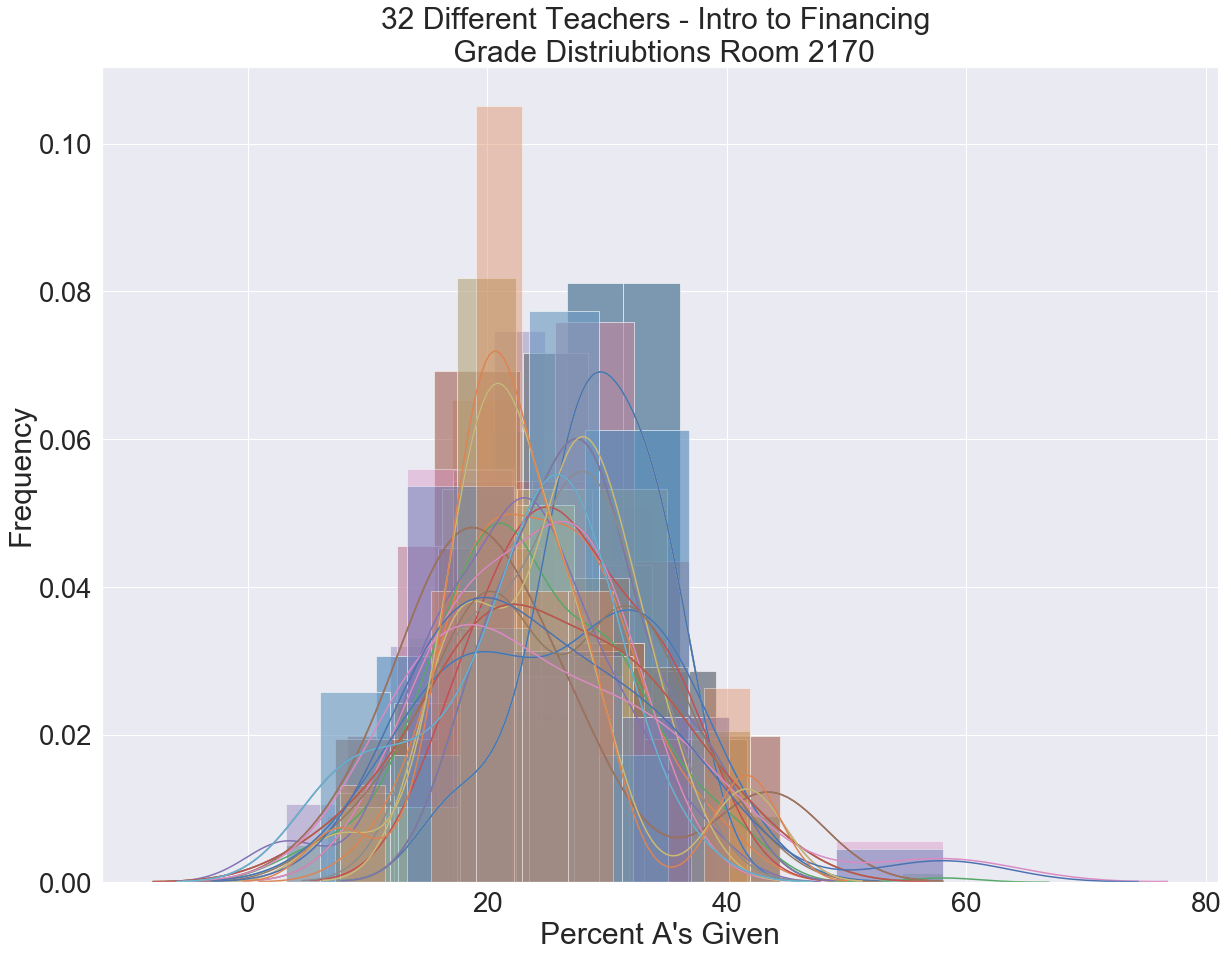

In [60]:
#Seaborn distplot of room 2170 Intro to Finance
sns.set_style('darkgrid')
sns.set(font_scale=2.5)

fig, ax = plt.subplots(figsize=(20,15))
for row in range(df_rc.get_group(room_course_list[0]).shape[0]):
    sns.distplot(df_rc.get_group(room_course_list[0]).iloc[row]['A']*100, label=df_rc.get_group(room_course_list[0]).iloc[row]['instructor_name'].split()[1],  ax = ax)
    
ax.set_title("32 Different Teachers - Intro to Financing \n Grade Distriubtions Room 2170")
ax.set_ylabel("Frequency")
ax.set_xlabel("Percent A's Given")



Text(0.5, 0, "Percent A's Given")

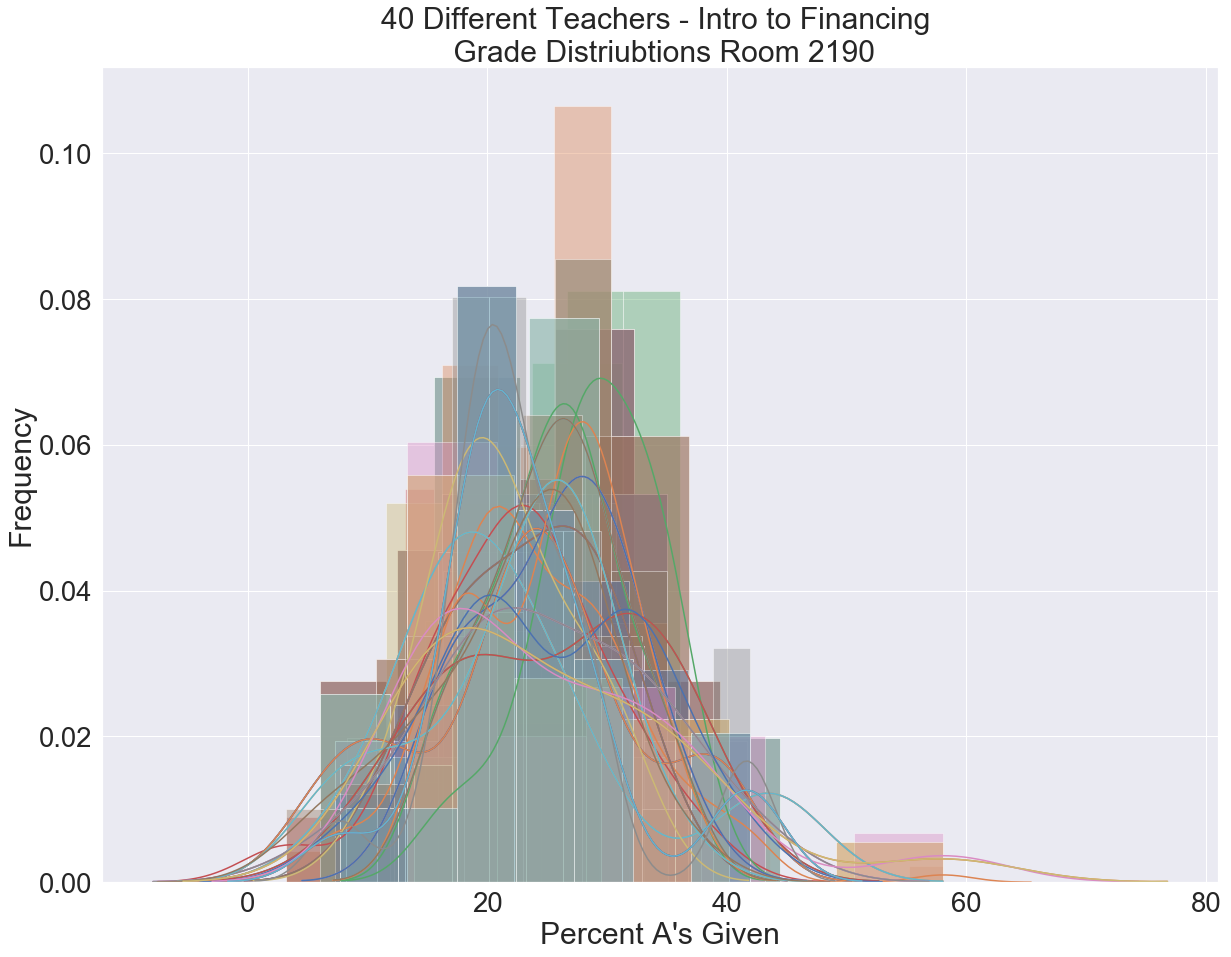

In [49]:
#Seaborn distplot of room 2190 Intro to Finance
sns.set_style('darkgrid')
sns.set(font_scale=2.5)
fig, ax = plt.subplots(figsize=(20,15))
for row in range(df_rc.get_group(room_course_list[1]).shape[0]):
    sns.distplot(df_rc.get_group(room_course_list[1]).iloc[row]['A']*100, label=df_rc.get_group(room_course_list[1]).iloc[row]['room_code'],  ax = ax)
    
ax.set_title("40 Different Teachers - Intro to Financing \n Grade Distriubtions Room 2190")
ax.set_ylabel("Frequency")
ax.set_xlabel("Percent A's Given")

In [80]:
#Make a master array for each room
Financing_2190 = []
for row in range(df_rc.get_group(room_course_list[1]).shape[0]):
    Financing_2190+=list(df_rc.get_group(room_course_list[1]).iloc[row]['A']*100)

Financing_2170 = []
for row in range(df_rc.get_group(room_course_list[0]).shape[0]):
    Financing_2170+=list(df_rc.get_group(room_course_list[0]).iloc[row]['A']*100)

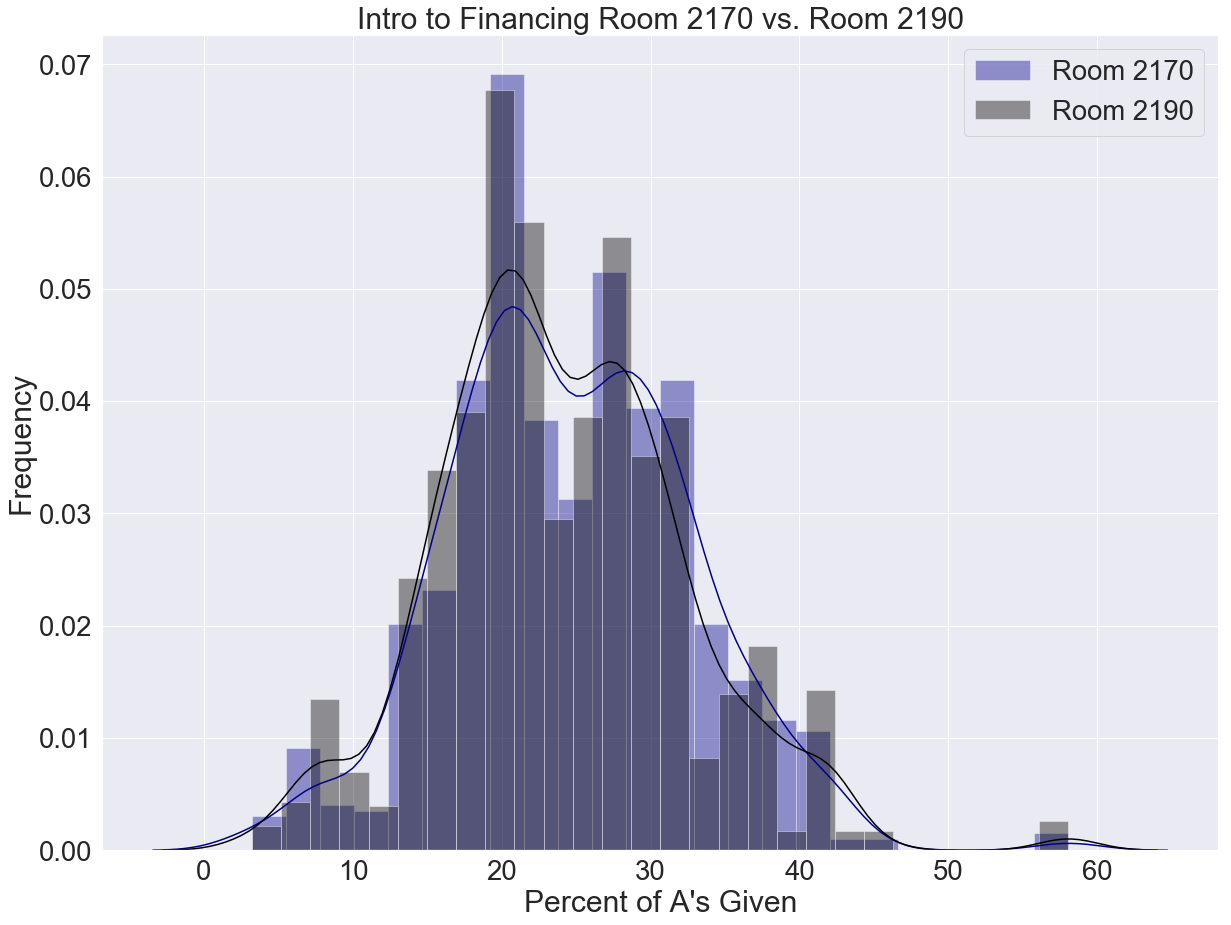

In [81]:
sns.set_style('whitegrid')
sns.set(font_scale=2.5)
fig, ax = plt.subplots(figsize=(20,15))

sns.distplot(Financing_2170,  ax = ax, color='darkblue', label='Room 2170')
sns.distplot(Financing_2190,  ax = ax, color='black', label='Room 2190')
    
ax.set_title("Intro to Financing Room 2170 vs. Room 2190")
ax.set_ylabel("Frequency")
ax.set_xlabel("Percent of A's Given")
ax.legend()


In [82]:
#null hypothesis -  the distributions are from the same underylying distribution
#alternative hypothesis - the distributions are from different underlying distributions
x = Financing_2170
y = Financing_2190
ttest=stats.ttest_ind(x,y)
print(f'The p-value for the two sided independent t test is:  {round(ttest[1],2)}')
print('The test fails to reject the null at the .05 level of significance.')
print('The effect size is: ', round(abs(np.array(Financing_2170).mean()-np.array(Financing_2190).mean()),8))

The p-value for the two sided independent t test is:  0.12
The test fails to reject the null at the .05 level of significance.
The effect size is:  0.57511578


In [97]:
print('The mean of room 2170 is: ', round(np.array(Financing_2170).mean(),2), '%\nThe mean of room 2190 is: ', round(np.array(Financing_2190).mean(),2),'%')


The mean of room 2170 is:  23.98 %
The mean of room 2190 is:  24.01 %


### Now looking again only with the same instructors in each room

In [22]:
#Create a new dataframe for each room
df_2170 = df_rc.get_group(room_course_list[0])
df_2190 = df_rc.get_group(room_course_list[1])

#Delete instructors that are not in both rooms
df_2190 = df_2190[df_2190.instructor_id.isin(instructors_2170)]
instructors_2190 = list(df_2190['instructor_id'])
df_2170 = df_2170[df_2170.instructor_id.isin(instructors_2190)]

Text(0.5, 0, "Percentage of A's given")

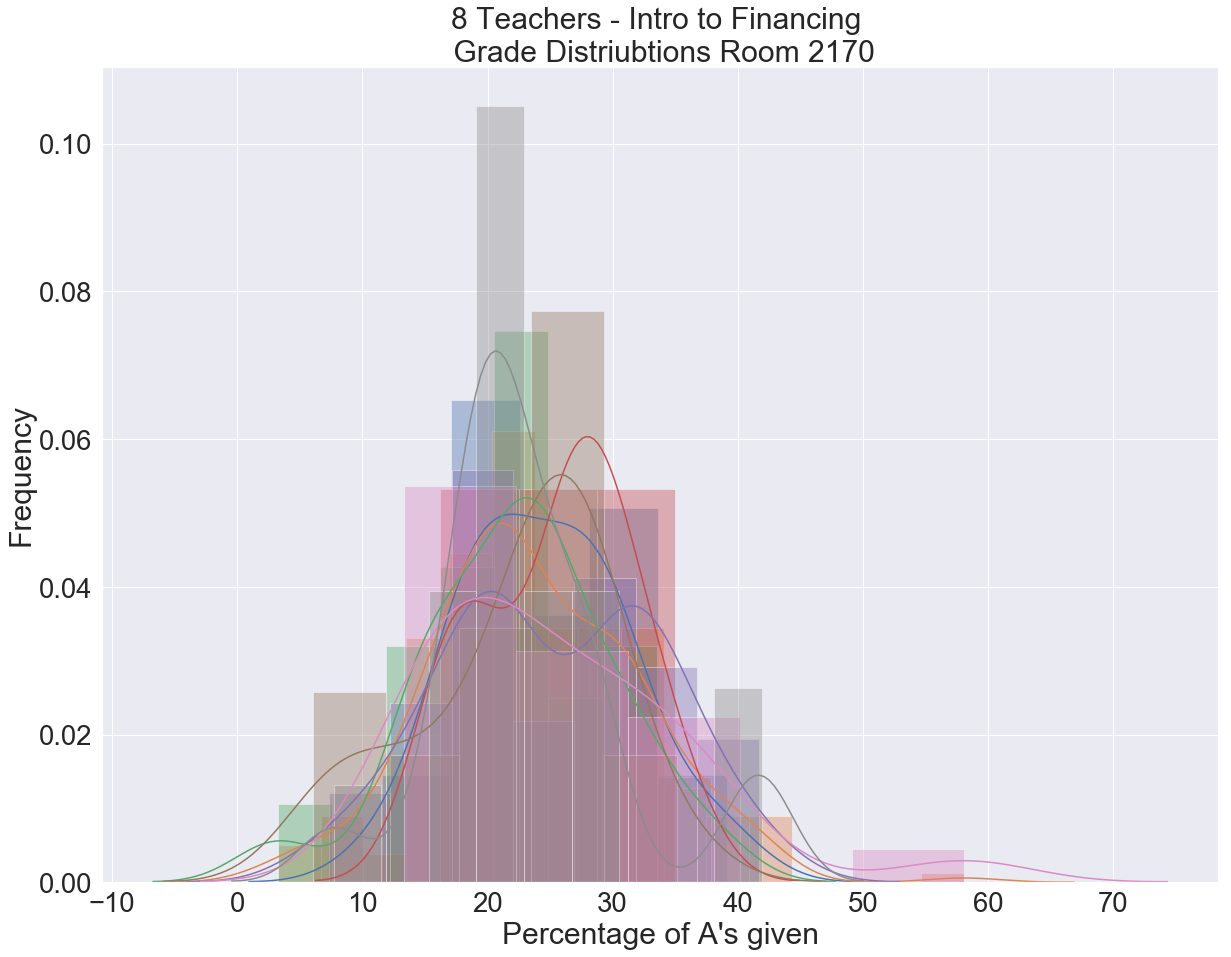

In [85]:
#Seaborn distplot of room 2170 Intro to Finance with only the 8 teachers that also have sections in room 2190
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(20,15))
#ax.title("32 Different Teachers - Intro to Financing - Grade Distriubtions Room 2170")
for row in range(df_2170.shape[0]):
    sns.distplot(df_2170.iloc[row]['A']*100,label=df_rc.get_group(room_course_list[0]).iloc[row]['instructor_name'],  ax = ax)
    
ax.set_title("8 Teachers - Intro to Financing \n Grade Distriubtions Room 2170")
ax.set_ylabel("Frequency")
ax.set_xlabel("Percentage of A's given")
#ax.legend()

Text(0.5, 0, "Percentage of A's Given")

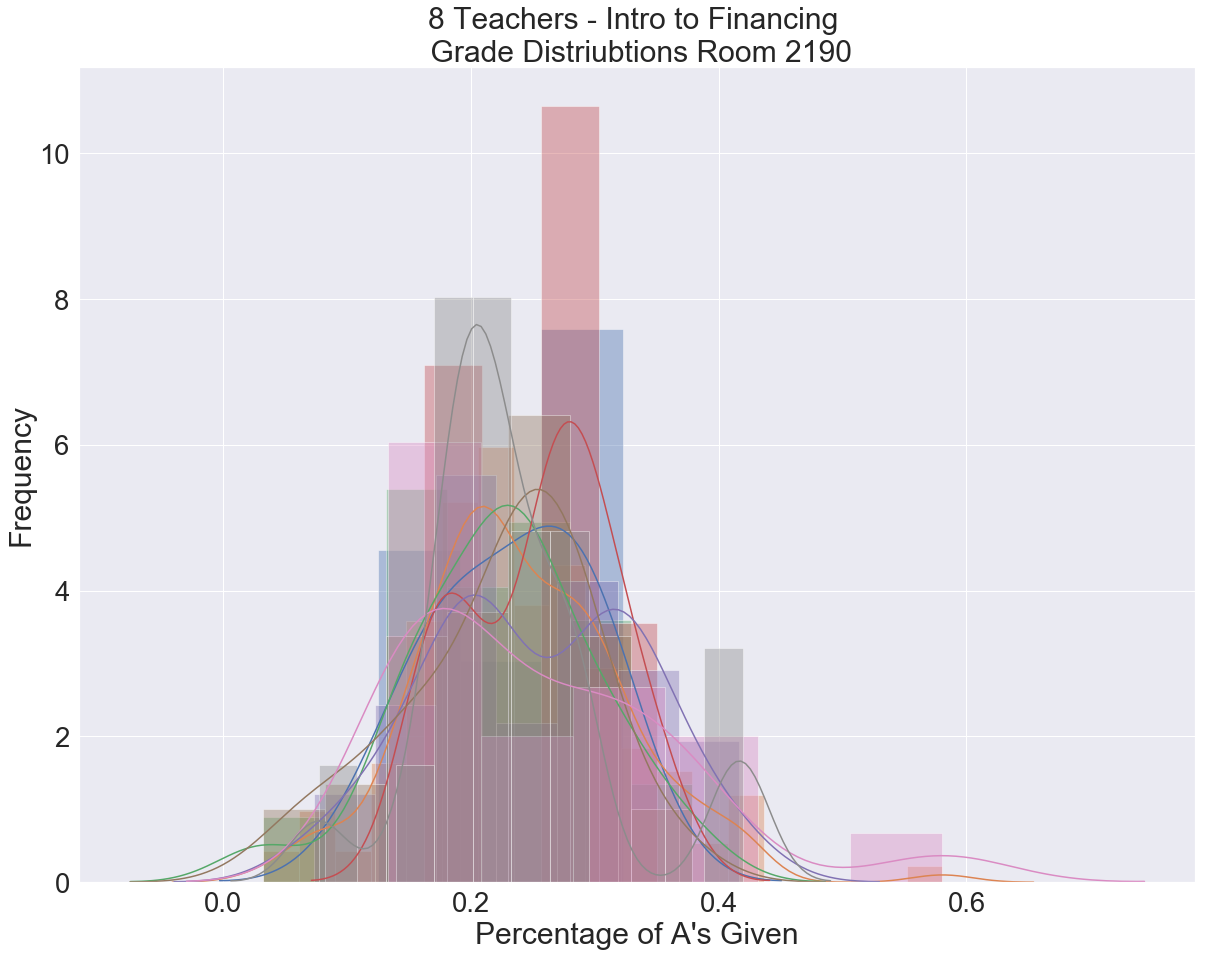

In [86]:
#Seaborn distplot of room 2190 Intro to Finance with only the 8 teachers that also have sections in room 2170
sns.set_style('darkgrid')

fig, ax = plt.subplots(figsize=(20,15))
#ax.title("32 Different Teachers - Intro to Financing - Grade Distriubtions Room 2170")
for row in range(df_2190.shape[0]):
    sns.distplot(df_2190.iloc[row]['A'], label=df_2190.iloc[row]['room_code'],  ax = ax)
    
ax.set_title("8 Teachers - Intro to Financing \n Grade Distriubtions Room 2190")
ax.set_ylabel("Frequency")
ax.set_xlabel("Percentage of A's Given")

### Now looking at the classrooms as a whole - sections/teachers melted together

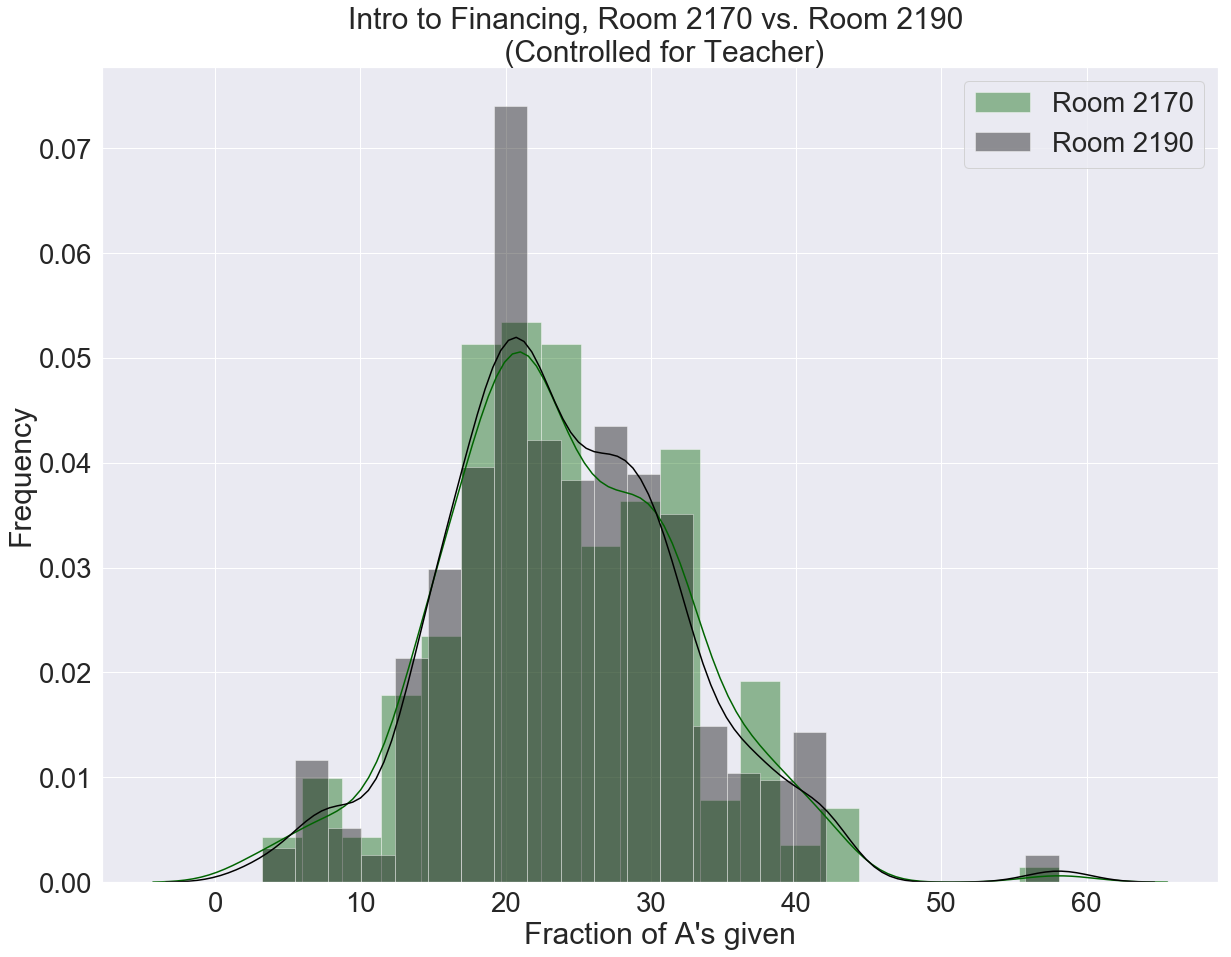

In [90]:


Financing_2170 = []
for row in range(df_2170.shape[0]):
    Financing_2170+=list(df_2170.iloc[row]['A']*100)
#Financing_2170

Financing_2190 = []
for row in range(df_2190.shape[0]):
    Financing_2190+=list(df_2190.iloc[row]['A']*100)
#Financing_2190

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(20,15))

sns.distplot(Financing_2170,  ax = ax, color='darkgreen', label='Room 2170')
sns.distplot(Financing_2190,  ax = ax, color='black', label='Room 2190')
    
ax.set_title("Intro to Financing, Room 2170 vs. Room 2190 \n (Controlled for Teacher)")
ax.set_ylabel("Frequency")
ax.set_xlabel("Fraction of A's given")
ax.legend()


### Two sided independent ttest on the distributions of ratio of A's given for the two classrooms

In [101]:
#null hypothesis -  the distributions are from the same underylying distribution
#alternative hypothesis - the distributions are from different underlying distributions
x = Financing_2170
y = Financing_2190
ttest=stats.ttest_ind(x,y)
print(f'The p-value for the two sided independent t test is:  {ttest[1]}')
print('The test fails to reject the null at the .05 level of significance.')
print('The effect size is: ', round(abs(np.array(Financing_2170).mean()-np.array(Financing_2190).mean()),8))

The p-value for the two sided independent t test is:  0.9491947471090479
The test fails to reject the null at the .05 level of significance.
The effect size is:  0.030802


In [100]:
print('The mean of room 2170 is: ', round(np.array(Financing_2170).mean(),2), '%\nThe mean of room 2190 is: ', round(np.array(Financing_2190).mean(),2),'%')


The mean of room 2170 is:  23.98 %
The mean of room 2190 is:  24.01 %


### Now looking at two new classrooms

In [27]:
df_4013 = df_rc.get_group(room_course_list[2])
df_4018 = df_rc.get_group(room_course_list[3])

instructors_4013 = list(df_4013['instructor_id'])
instructors_4018 = list(df_4018['instructor_id'])

Text(0.5, 0, "Fraction of A's given")

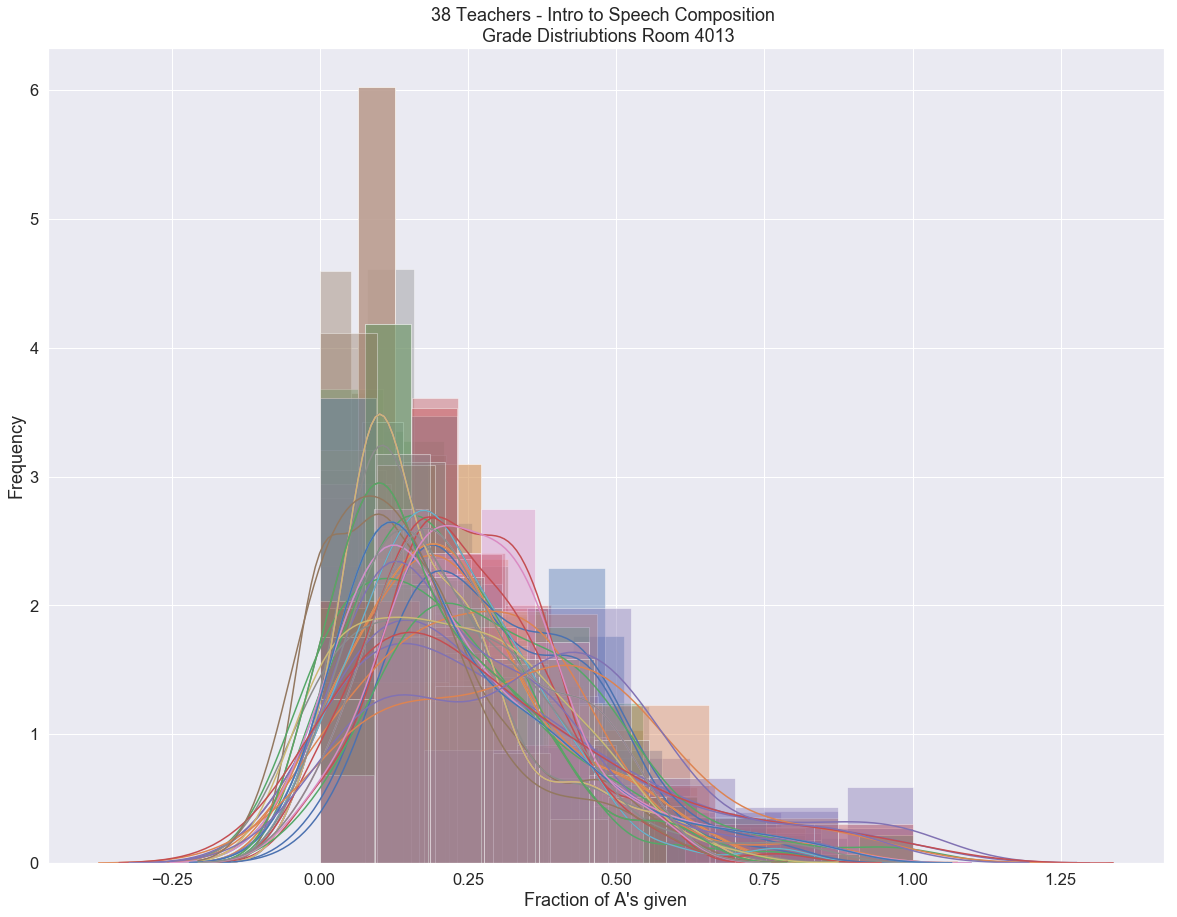

In [28]:
#Seaborn distplot of room 4013 Speech Composition
sns.set_style('darkgrid')

fig, ax = plt.subplots(figsize=(20,15))

for row in range(df_4013.shape[0]):
    sns.distplot(df_4013.iloc[row]['A'],  ax = ax)
    
ax.set_title("38 Teachers - Intro to Speech Composition \n Grade Distriubtions Room 4013")
ax.set_ylabel("Frequency")
ax.set_xlabel("Fraction of A's given")

Text(0.5, 0, "Fraction of A's given")

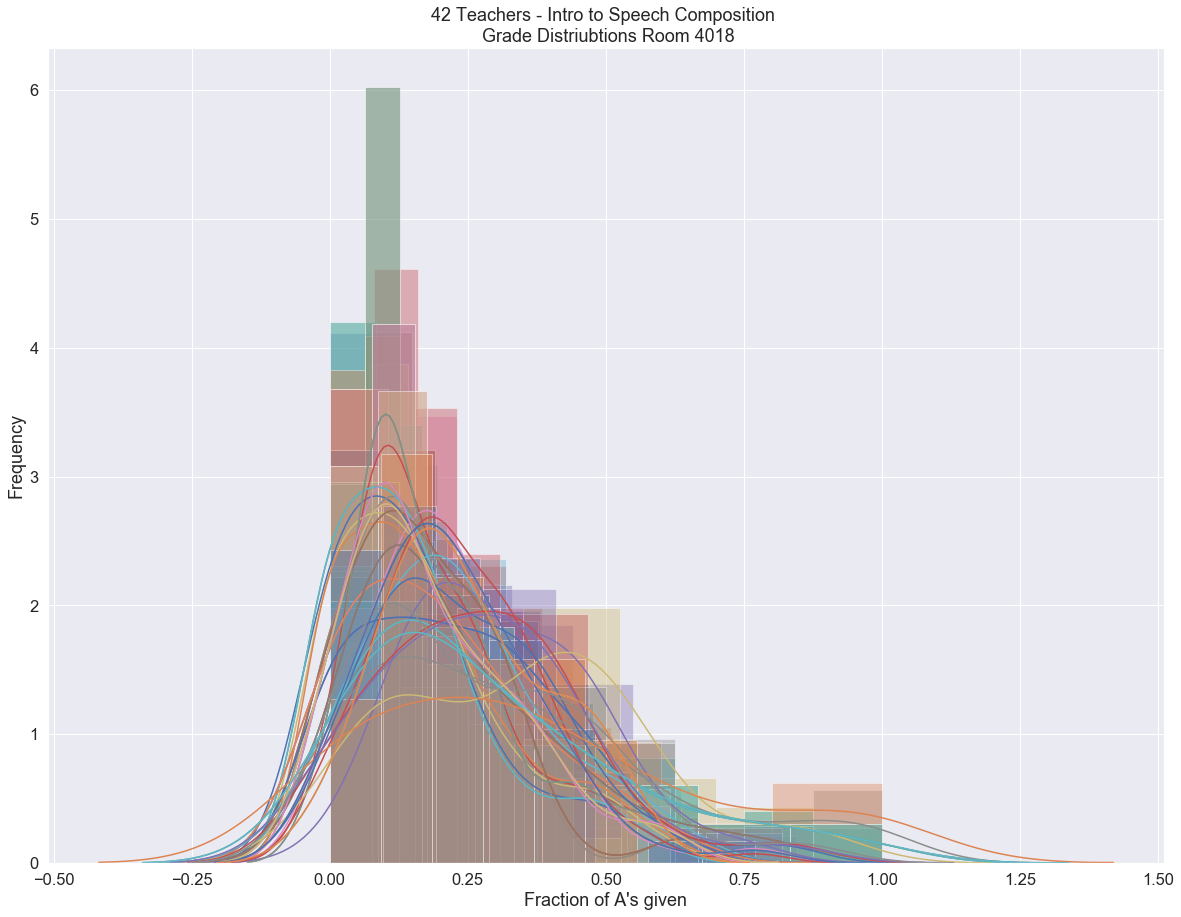

In [29]:
#Seaborn distplot of room 4018 Speech Composition
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(20,15))

for row in range(df_4018.shape[0]):
    sns.distplot(df_4018.iloc[row]['A'],  ax = ax)
    
ax.set_title("42 Teachers - Intro to Speech Composition \n Grade Distriubtions Room 4018")
ax.set_ylabel("Frequency")
ax.set_xlabel("Fraction of A's given")

### Now looking at the two classrooms with sections and teachers all together

In [30]:

Speech_4013 = []
for row in range(df_4013.shape[0]):
    Speech_4013+=list(df_4013.iloc[row]['A'])

Speech_4018 = []
for row in range(df_4018.shape[0]):
    Speech_4018+=list(df_4018.iloc[row]['A'])

Text(0.5, 0, "Fraction of A's given")

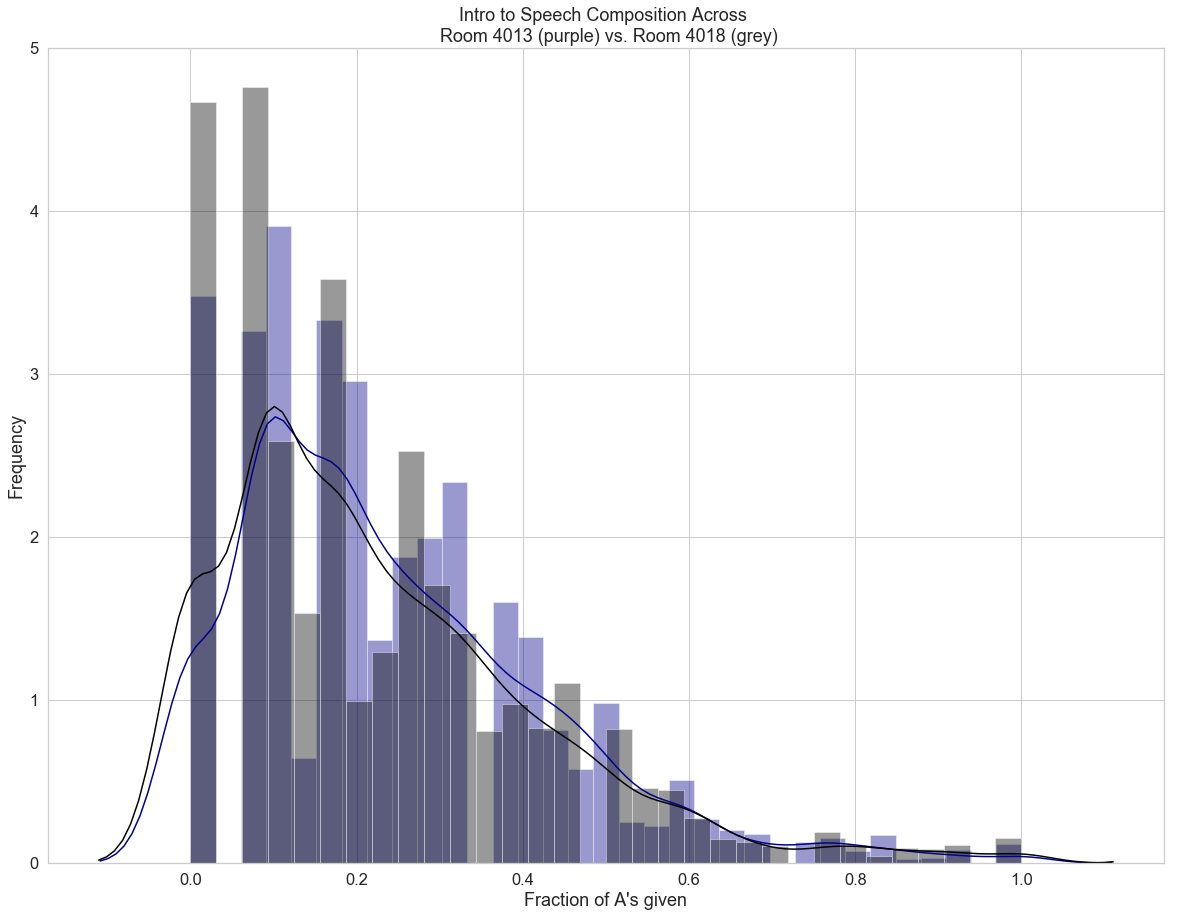

In [31]:
#Seaborn distplot of room 4013 vs room 4018 Speech Composition 
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(20,15))

sns.distplot(Speech_4013,  ax = ax, color='darkblue')
sns.distplot(Speech_4018,  ax = ax, color='black')
    
ax.set_title("Intro to Speech Composition Across \n Room 4013 (purple) vs. Room 4018 (grey)")
ax.set_ylabel("Frequency")
ax.set_xlabel("Fraction of A's given")

In [32]:
#null hypothesis -  the distributions are from the same underylying distribution
#alternative hypothesis - the distributions are from different underlying distributions
x = Speech_4013
y = Speech_4018
ttest=stats.ttest_ind(x,y)
print(f'The p-value for the two sided independent t test is:  {ttest[1]}')
print('The test rejects the null at the .05 level of significance.')
print('The effect size is : ', (np.array(Speech_4013).mean()-np.array(Speech_4018).mean()))

The p-value for the two sided independent t test is:  0.0012359938987117538
The test rejects the null at the .05 level of significance.
The effect size is :  0.01385333037773917


In [33]:
#Get rid of rows that represent teachers that do not teach in both classrooms
df_4018 = df_4018[df_4018.instructor_id.isin(instructors_4013)]
instructors_4018 = list(df_4018['instructor_id'])
df_4013 = df_4013[df_4013.instructor_id.isin(instructors_4018)]


Text(0.5, 0, "Percentage of A's given")

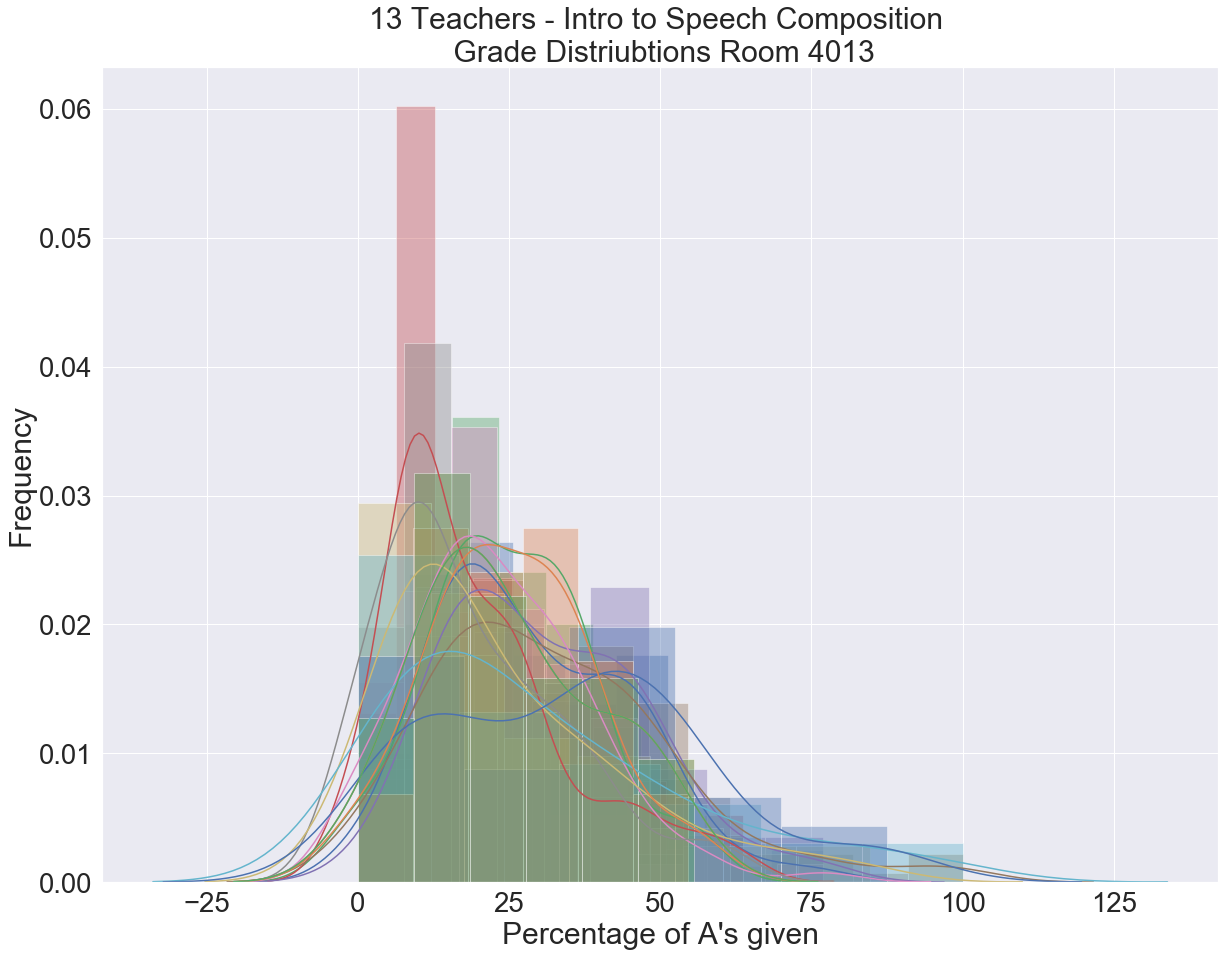

In [102]:
#Seaborn distplot of room 4013 Speech Composition with only the teachers also teaching in 4018
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(20,15))

for row in range(df_4013.shape[0]):
    sns.distplot(df_4013.iloc[row]['A']*100,  ax = ax)
    
ax.set_title("13 Teachers - Intro to Speech Composition \n Grade Distriubtions Room 4013")
ax.set_ylabel("Frequency")
ax.set_xlabel("Percentage of A's given")

Text(0.5, 0, "Percentage of A's Given")

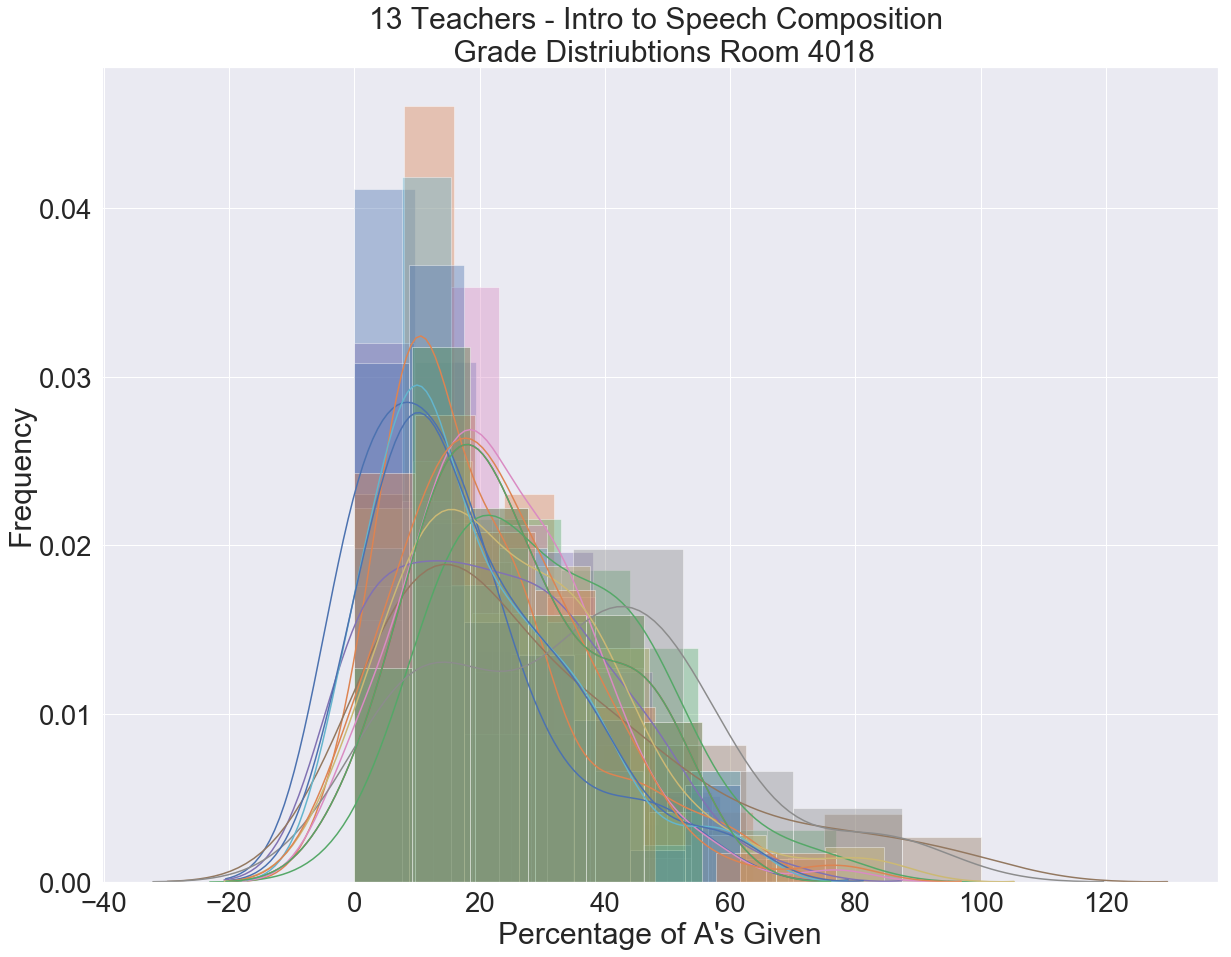

In [103]:
#Seaborn distplot of room 4018 Speech Composition with only the teachers also teaching in 4018
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(20,15))

for row in range(df_4018.shape[0]):
    sns.distplot(df_4018.iloc[row]['A']*100,  ax = ax)
    
ax.set_title("13 Teachers - Intro to Speech Composition \n Grade Distriubtions Room 4018")
ax.set_ylabel("Frequency")
ax.set_xlabel("Percentage of A's Given")

In [104]:
#Melt all the sections/teachers into on array
Speech_4013 = []
for row in range(df_4013.shape[0]):
    Speech_4013+=list(df_4013.iloc[row]['A']*100)

Speech_4018 = []
for row in range(df_4018.shape[0]):
    Speech_4018+=list(df_4018.iloc[row]['A']*100)

Text(0.5, 0, "Percentage of A's given")

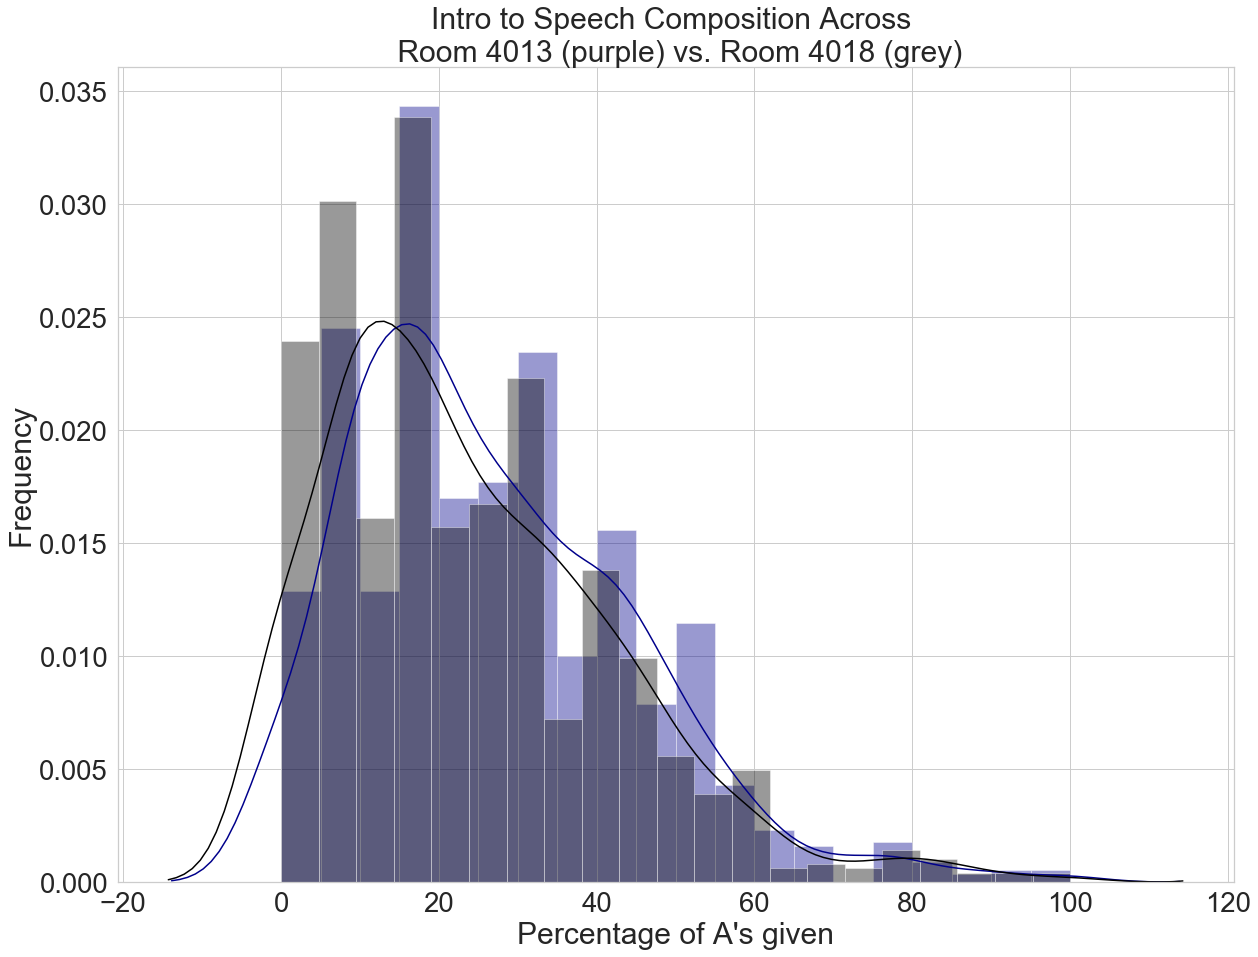

In [105]:
#Seaborn distplot of room 4013 vs room 4018 Speech Composition with only the teachers that teach in both classrooms
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(20,15))

sns.distplot(Speech_4013,  ax = ax, color='darkblue')
sns.distplot(Speech_4018,  ax = ax, color='black')
    
ax.set_title("Intro to Speech Composition Across \n Room 4013 (purple) vs. Room 4018 (grey)")
ax.set_ylabel("Frequency")
ax.set_xlabel("Percentage of A's given")

In [107]:
print('The mean of room 2170 is: ', round(np.array(Speech_4013).mean(),2), '%\nThe mean of room 2190 is: ', round(np.array(Speech_4018).mean(),2),'%')


The mean of room 2170 is:  26.48 %
The mean of room 2190 is:  23.8 %


In [38]:
#null hypothesis -  the distributions are from the same underylying distribution
#alternative hypothesis - the distributions are from different underlying distributions
x = Speech_4013
y = Speech_4018
ttest=stats.ttest_ind(x,y)
print(f'The p-value for the two sided independent t test is:  {ttest[1]}')
print('The test rejects the null at the .05 level of significance.')

print('The effect size is: ', np.array(Speech_4013).mean()-np.array(Speech_4018).mean())


The p-value for the two sided independent t test is:  0.0005834813532141896
The test rejects the null at the .05 level of significance.
The effect size is:  0.026780696431120438
